In [204]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier, cv, Pool, CatBoost
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [205]:
age_gender_df = pd.read_csv("alter_geschlecht.csv")
interests_df = pd.read_csv("interesse.csv")
rest_df = pd.read_csv("rest.csv")

Check Each dataframe to understand the data better and look for unknown entries

In [206]:
age_gender_null_value_stats = age_gender_df.isnull().sum(axis=0)
age_gender_null_value_stats[age_gender_null_value_stats != 0]

Series([], dtype: int64)

In [207]:
age_gender_df.head()

,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24
2,369321,Female,30
3,500463,Female,32
4,327695,Male,34


In [208]:
age_gender_df.describe()

,id,Alter
count,508146.000000,508146.000000
mean,254073.500000,38.808413
std,146689.259281,15.500179
min,1.000000,20.000000
25%,127037.250000,25.000000
50%,254073.500000,36.000000
75%,381109.750000,49.000000
max,508146.000000,85.000000


In [209]:
interests_null_value_stats = interests_df.isnull().sum(axis=0)
interests_null_value_stats[interests_null_value_stats != 0]

Series([], dtype: int64)

In [210]:
interests_df.head()

,id,Interesse
0,1,1.0
1,2,0.0
2,3,1.0
3,4,0.0
4,5,0.0


In [211]:
interests_df.describe()

,id,Interesse
count,381109.000000,381109.000000
mean,190555.000000,0.122563
std,110016.836208,0.327936
min,1.000000,0.000000
25%,95278.000000,0.000000
50%,190555.000000,0.000000
75%,285832.000000,0.000000
max,381109.000000,1.000000


In [212]:
rest_null_value_stats = rest_df.isnull().sum(axis=0)
rest_null_value_stats[rest_null_value_stats != 0]

Series([], dtype: int64)

In [213]:
rest_df.head()

,Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id
0,1;15.0;1;1-2 Year;No;2630.0;124.0;74;317635
1,1;28.0;0;1-2 Year;Yes;2630.0;125.0;213;337993
2,1;33.0;0;1-2 Year;Yes;27204.0;124.0;114;160325
3,1;46.0;1;< 1 Year;No;31999.0;152.0;251;141620
4,1;49.0;0;1-2 Year;Yes;28262.0;26.0;60;75060


In [214]:
rest_df.describe()

,Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id
count,508146
unique,508146
top,1;15.0;1;1-2 Year;No;2630.0;124.0;74;317635
freq,1


Properly separate features by column

In [215]:
rest_df[["Fahrerlaubnis", "Regional_Code", "Vorversicherung", "Alter_Fzg", "Vorschaden", "Jahresbeitrag", "Vertriebskanal","Kundentreue","id"]]= rest_df['Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id'].str.split(';', n=-1, expand=True)

In [216]:
rest_df = rest_df.drop("Fahrerlaubnis;Regional_Code;Vorversicherung;Alter_Fzg;Vorschaden;Jahresbeitrag;Vertriebskanal;Kundentreue;id", axis=1)
rest_df.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.0,1,1-2 Year,No,2630.0,124.0,74,317635
1,1,28.0,0,1-2 Year,Yes,2630.0,125.0,213,337993
2,1,33.0,0,1-2 Year,Yes,27204.0,124.0,114,160325
3,1,46.0,1,< 1 Year,No,31999.0,152.0,251,141620
4,1,49.0,0,1-2 Year,Yes,28262.0,26.0,60,75060


In [217]:
rest_df.describe()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
count,508146,508146,508146,508146,508146,508146,508146,508146,508146
unique,2,53,2,3,2,52062,157,290,508146
top,1,28.0,0,1-2 Year,Yes,2630.0,152.0,256,317635
freq,507097,141937,275076,267015,256248,86488,179523,1877,1


In [218]:
rest_df['id']= rest_df['id'].astype(int)

Merge data into a single frame for easier manipulation

In [219]:
merged_df = pd.merge(age_gender_df, rest_df, on='id', how='outer')
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [220]:
merged_df =pd.merge(merged_df, interests_df, on='id', how='outer')

Clean feature formatting (numerical and categorical features)

In [221]:
merged_df['Regional_Code']= merged_df['Regional_Code'].astype(float).astype(int)
merged_df['Vertriebskanal']= merged_df['Vertriebskanal'].astype(float).astype(int)
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1.0
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0.0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1.0
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0.0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0.0


In [222]:
merged_df_null_value_stats = merged_df.isnull().sum(axis=0)
merged_df_null_value_stats[merged_df_null_value_stats != 0]

Interesse    127037
dtype: int64

In [223]:
unknown_rows= merged_df[merged_df['Interesse'].isna()]
unknown_rows.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
381109,381110,Male,25,1,11,1,< 1 Year,No,35786.0,152,53,NaN
381110,381111,Male,40,1,28,0,1-2 Year,Yes,33762.0,7,111,NaN
381111,381112,Male,47,1,28,0,1-2 Year,Yes,40050.0,124,199,NaN
381112,381113,Male,24,1,27,1,< 1 Year,Yes,37356.0,152,187,NaN
381113,381114,Male,27,1,28,1,< 1 Year,No,59097.0,152,297,NaN


Remove rows where interest of customer is unknown

In [224]:
merged_df = merged_df[merged_df['Interesse'].notna()]
merged_df_null_value_stats = merged_df.isnull().sum(axis=0)
print(merged_df_null_value_stats[merged_df_null_value_stats != 0])


Series([], dtype: int64)


In [225]:

merged_df['Interesse'] = merged_df['Interesse'].astype(bool)
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,True
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,False
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,True
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,False
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,False


In [226]:
merged_df['Alter_Fzg'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

Create a pipeline that handles the One Hot encoding of categorical features and uses a decision tree classifier as estimator

In [227]:
merged_df['Kundentreue']= merged_df['Kundentreue'].astype(int)
merged_df['Jahresbeitrag']= merged_df['Jahresbeitrag'].astype(float)
merged_df['Fahrerlaubnis']= merged_df['Fahrerlaubnis'].astype(bool)
merged_df['Vorversicherung']= merged_df['Vorversicherung'].astype(bool)

In [228]:
categorical_cols =['Geschlecht', 'Alter_Fzg','Vorschaden']

categorical_pipe = Pipeline(steps=[
                            ('oh_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
dt_transformer = ColumnTransformer(transformers =[                
                                        ('categorical_pipe', categorical_pipe, categorical_cols)
],
                                        remainder = 'drop',
                                        n_jobs =-1)
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier_pipeline = make_pipeline(dt_transformer, dt_classifier)

In [229]:
X = merged_df.drop(['Interesse'],axis=1)
y= merged_df['Interesse']

Perform stratified cross validation for balanced class representation and investigate log loss (metric commonly used for binary classification tasks) of model

In [188]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#dt_classifier_scores= 
dt_cv=cross_validate(dt_classifier_pipeline,X,y,cv=skf,verbose=1,return_train_score=True,return_estimator=True,scoring = ['neg_log_loss']) #'accuracy'])


In [189]:
dt_cv

{'fit_time': array([1.36586142, 1.67713261, 1.21190357, 1.21338725, 1.22540879]),
 'score_time': array([0.2378056 , 0.19904542, 0.19387031, 0.21898174, 0.19768763]),
 'estimator': [Pipeline(steps=[('columntransformer',
                   ColumnTransformer(n_jobs=-1,
                                     transformers=[('categorical_pipe',
                                                    Pipeline(steps=[('oh_encoder',
                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                   sparse_output=False))]),
                                                    ['Geschlecht', 'Alter_Fzg',
                                                     'Vorschaden'])])),
                  ('decisiontreeclassifier',
                   DecisionTreeClassifier(random_state=42))]),
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(n_jobs=-1,
              

In [190]:
print(f"Train log loss {dt_cv['train_neg_log_loss']*-1}")
print(f"Test log loss{dt_cv['test_neg_log_loss']*-1}")

#print(f"Train accuracy {dt_cv['train_accuracy']}")
#print(f"Test accuracy{dt_cv['test_accuracy']}")

Train log loss [0.28747159 0.28786419 0.28756807 0.28777364 0.28776114]
Test log loss[0.2886002  0.28701367 0.28819829 0.28736682 0.2874206 ]


In [198]:
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'learning_rate': 0.5,
}

Helper method for easier visualisation of cross validation results

In [192]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )

In [193]:
cat_pool = Pool(data=X,label =y,cat_features=categorical_cols)

In [201]:
catboost_cv_data, fitted_cat_model = cv(
    params = params,
    pool = cat_pool,
    fold_count=4,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=True,
    verbose=False,
    early_stopping_rounds=15,
    return_models = True
    
)

print_cv_summary(catboost_cv_data)   

Training on fold [0/4]

bestTest = 0.2739669742
bestIteration = 42

Training on fold [1/4]

bestTest = 0.2740239264
bestIteration = 40

Training on fold [2/4]

bestTest = 0.2734793453
bestIteration = 32

Training on fold [3/4]

bestTest = 0.2729554552
bestIteration = 36

Best validation Logloss score : 0.2736±0.0005 on step 40


In [202]:
grid = {'iterations': [50, 75, 100],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1]}
cat_classifier= CatBoostClassifier()

In [203]:
 cat_classifier.grid_search(grid,
             cat_pool,
             cv=skf,
             partition_random_seed=0,
             calc_cv_statistics=True,
             search_by_train_test_split=True,
             refit=True,
            shuffle=True,
             stratified=None,
             train_size=0.8,
              plot=False)

C:\Users\Samantha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


0:	learn: 0.6507136	test: 0.6505600	best: 0.6505600 (0)	total: 180ms	remaining: 5.22s
1:	learn: 0.6120224	test: 0.6117241	best: 0.6117241 (1)	total: 378ms	remaining: 5.29s
2:	learn: 0.5775085	test: 0.5770772	best: 0.5770772 (2)	total: 592ms	remaining: 5.33s
3:	learn: 0.5466744	test: 0.5461269	best: 0.5461269 (3)	total: 812ms	remaining: 5.28s
4:	learn: 0.5193526	test: 0.5186959	best: 0.5186959 (4)	total: 1.17s	remaining: 5.83s
5:	learn: 0.4949603	test: 0.4942042	best: 0.4942042 (5)	total: 1.56s	remaining: 6.26s
6:	learn: 0.4736469	test: 0.4728051	best: 0.4728051 (6)	total: 1.74s	remaining: 5.7s
7:	learn: 0.4551678	test: 0.4542647	best: 0.4542647 (7)	total: 1.91s	remaining: 5.26s
8:	learn: 0.4381010	test: 0.4371144	best: 0.4371144 (8)	total: 2.07s	remaining: 4.82s
9:	learn: 0.4231690	test: 0.4221314	best: 0.4221314 (9)	total: 2.25s	remaining: 4.49s
10:	learn: 0.4099256	test: 0.4088355	best: 0.4088355 (10)	total: 2.41s	remaining: 4.17s
11:	learn: 0.3982835	test: 0.3971423	best: 0.3971423 

KeyboardInterrupt: 

In [197]:
fitted_cat_model[0][0]

TypeError: 'CatBoost' object is not subscriptable

In [ ]:
model.save_model('model_name')    # extension not required.

# And then, later load - 
from catboost import CatBoostClassifier
model = CatBoostClassifier()      # parameters not required.
model.load_model('model_name')

TRASH ZONE: 

In [35]:
mappings = {
    '> 2 Years': '2',
    '1-2 Year': '1',
    '<1 Year': '0'
}  
merged_df['Alter_Fzg']= merged_df['Alter_Fzg'].map(mappings)

In [36]:
merged_df['Alter_Fzg']= merged_df['Alter_Fzg'].fillna('0')
merged_df['Alter_Fzg']= merged_df['Alter_Fzg'].astype(int)

In [37]:
merged_df['Alter_Fzg'].unique()

array([2, 1, 0])

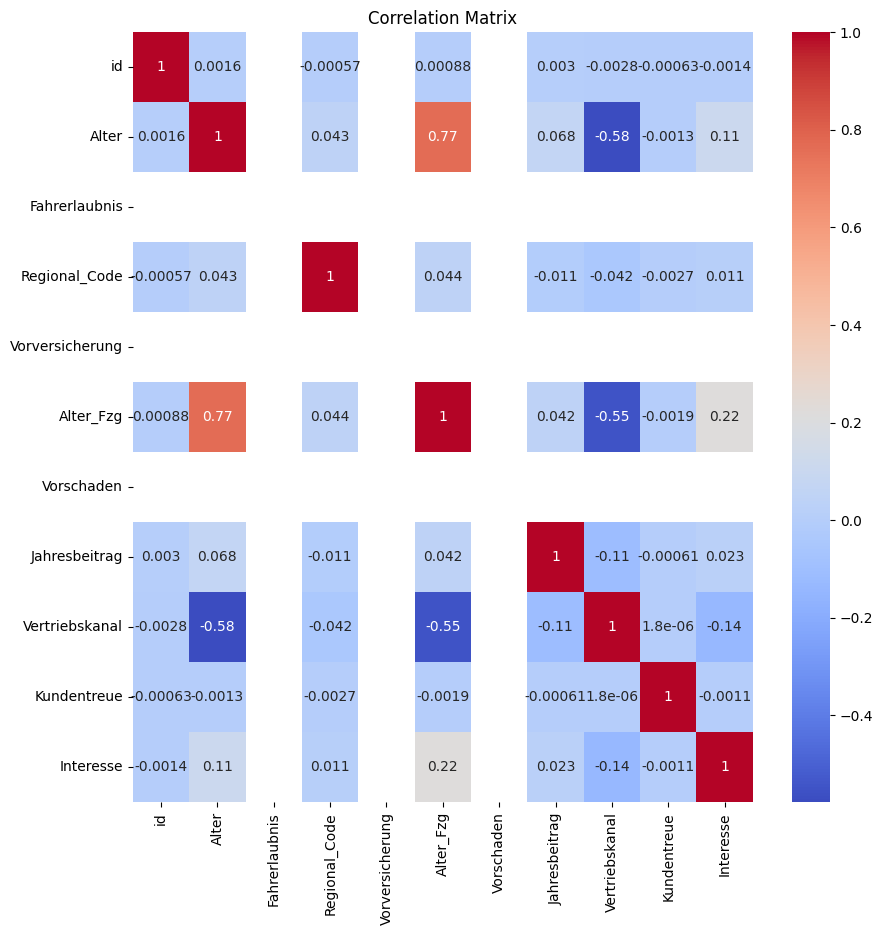

In [39]:
correlation_matrix = merged_df.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [40]:
merged_df.dtypes

id                   int64
Geschlecht          object
Alter                int64
Fahrerlaubnis         bool
Regional_Code        int32
Vorversicherung       bool
Alter_Fzg            int32
Vorschaden            bool
Jahresbeitrag      float64
Vertriebskanal       int32
Kundentreue          int32
Interesse             bool
dtype: object

In [41]:
merged_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Interesse
0,1,Male,44,True,28,True,2,True,40454.0,26,217,True
1,2,Male,76,True,3,True,1,True,33536.0,26,183,False
2,3,Male,47,True,28,True,2,True,38294.0,26,27,True
3,4,Male,21,True,11,True,0,True,28619.0,152,203,False
4,5,Female,29,True,41,True,0,True,27496.0,152,39,False


In [42]:
dt_classifier = DecisionTreeClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42,  
                                   test_size=0.25,  
                                   shuffle=True) 
